# 사진 준비하기

1. 얼굴이 포함된 사진을 준비하고
2. 사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)
3. 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.

In [ ]:
# !pip install opencv-python
# !pip install cmake
# !pip install dlib # dlib 패키지 설치

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [ ]:
img_bgr = cv2.imread('./data/img/Itzy.png')
img_bgr = cv2.resize(img_bgr, (640, 320))
img_show = img_bgr.copy() # 출력용 이미지 복사

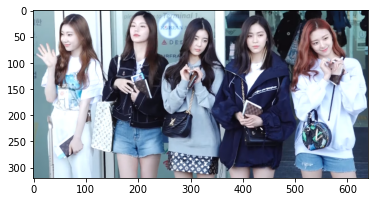

In [21]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

 cv2.imread('img.png', 0) 에서 0은 이미지를 Grayscale로 읽어 들입니다.

# 얼굴 검출 face detection

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서  
SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.

In [22]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)
print("🌫🛸")

rectangles[[(40, 31) (84, 74)], [(405, 36) (448, 79)], [(530, 46) (573, 89)], [(297, 46) (333, 82)], [(181, 22) (217, 58)]]
🌫🛸


rectangles[[(40, 31) (84, 74)], [(405, 36) (448, 79)], [(530, 46) (573, 89)], [(297, 46) (333, 82)], [(181, 22) (217, 58)]]


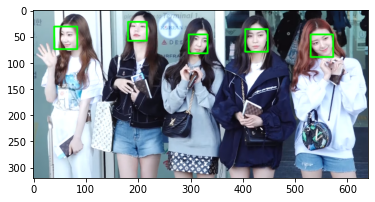

In [24]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 랜드마크 face landmark

In [ ]:
# $ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# $ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
# $ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [41]:
import os
model_path = './data/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [50]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

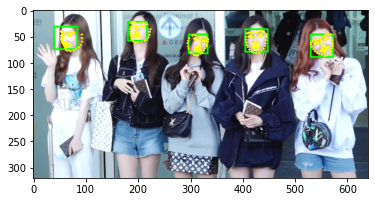

In [52]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용하기

In [55]:
for dlib_rect,landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('(x,y): (%d,%d)'%(x,y))
    print('(w,h):(%d,%d)'%(w,h))

(55, 58)
(x,y): (55,36)
(w,h):(45,45)
(424, 60)
(x,y): (424,38)
(w,h):(44,44)
(554, 70)
(x,y): (554,48)
(w,h):(44,44)
(318, 67)
(x,y): (318,49)
(w,h):(37,37)
(196, 36)
(x,y): (196,18)
(w,h):(37,37)


각 얼굴의 좌표를 확인해 보았습니다.  
총 5개의 좌표가 나오게 됩니다.  
여기서 y-w//2를 해주는 이유는 그 좌표에 모자를 씌울 것 이기 때문입니다. 

In [71]:
import os 
sticker_path = './data/img/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

(37, 37, 3)


준비해 둔 스티커 이미지를 읽어서 적용해 보았습니다.

In [72]:
refined_x = x-w//2
refined_y = y-h
print('(x,y):(%d, %d)'%(refined_x, refined_y))

(x,y):(178, -19)


이제 스티커를 적용 시키기 위해서 x-w//2를 해주네요.  
쉽게 말해서 좌표를 좌측, 상단 꼭지점에 두는 것 입니다.  
그런데 여기서 왜 음수가 나왔을까요?  
바로 사진의 크기를 벗어났기 때문입니다.  
그래서 사진 규격에 맞춰 스티커의 윗부분을 잘라내야 됩니다. 

In [73]:
print('자르기 전: ', img_sticker.shape)
img_sticker = img_sticker[-refined_y:]
print('자른 후: ',img_sticker.shape)

자르기 전:  (37, 37, 3)
자른 후:  (18, 37, 3)


스티커 이미지의 y축(행)이 잘린 모습을 확인 할 수 있습니다. 

In [75]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (178,0)


이제 스티커를 잘랐으니까 음수로된 y 좌표를 0으로 바꿔줍시다.

In [78]:
x_shape = img_sticker.shape[0]
y_shape = img_sticker.shape[1]
print('(x_shape,y_shape) : (%d,%d)'%(x_shape, y_shape))

sticker_area = img_show[refined_y:x_shape, refined_x:refined_x+y_shape]
img_show[refined_y:x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

(x_shape,y_shape) : (18,37)


위의 코드는 원본 이미지에 스티커를 적용하는 코드입니다.  
먼저 sticker_area로 스티커가 차지하는 영역을 지정해 줍니다.  
여기서는 y가 0이기 때문에 refined_y:x_shape을 한 것 같네요.

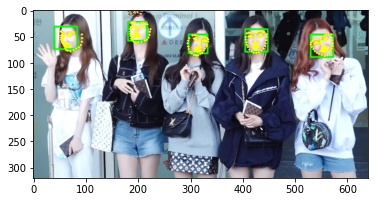

In [79]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

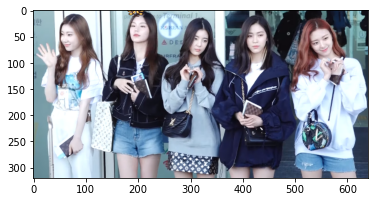

In [81]:
sticker_area = img_bgr[refined_y:x_shape, refined_x:refined_x+y_shape]
img_bgr[refined_y:x_shape, refined_x:refined_x+y_shape] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(2, cv2.COLOR_BGR2RGB))
plt.show()